#Import necessary libraries and get the data

In [2]:
# Import necessary libraries
import pandas as pd

# Load the data
df = pd.read_csv('/content/winequality-red.csv', delimiter=';')

# Display the first few rows of the dataset
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#Discover and Visualize the Data to Gain Insights

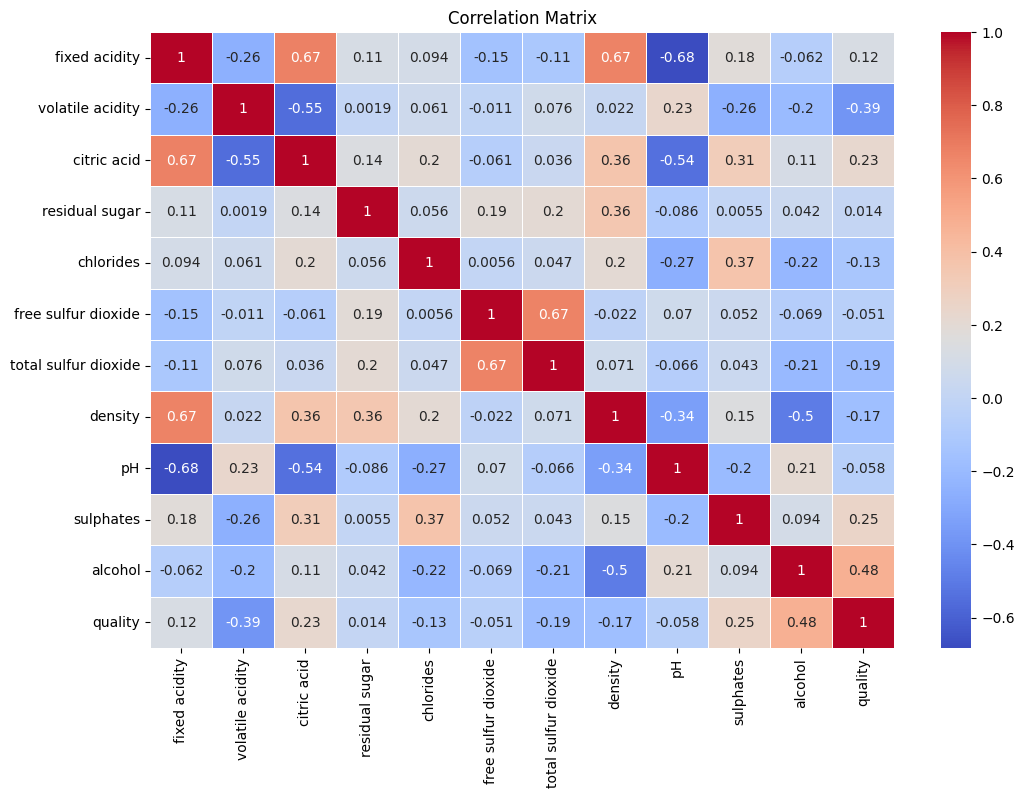

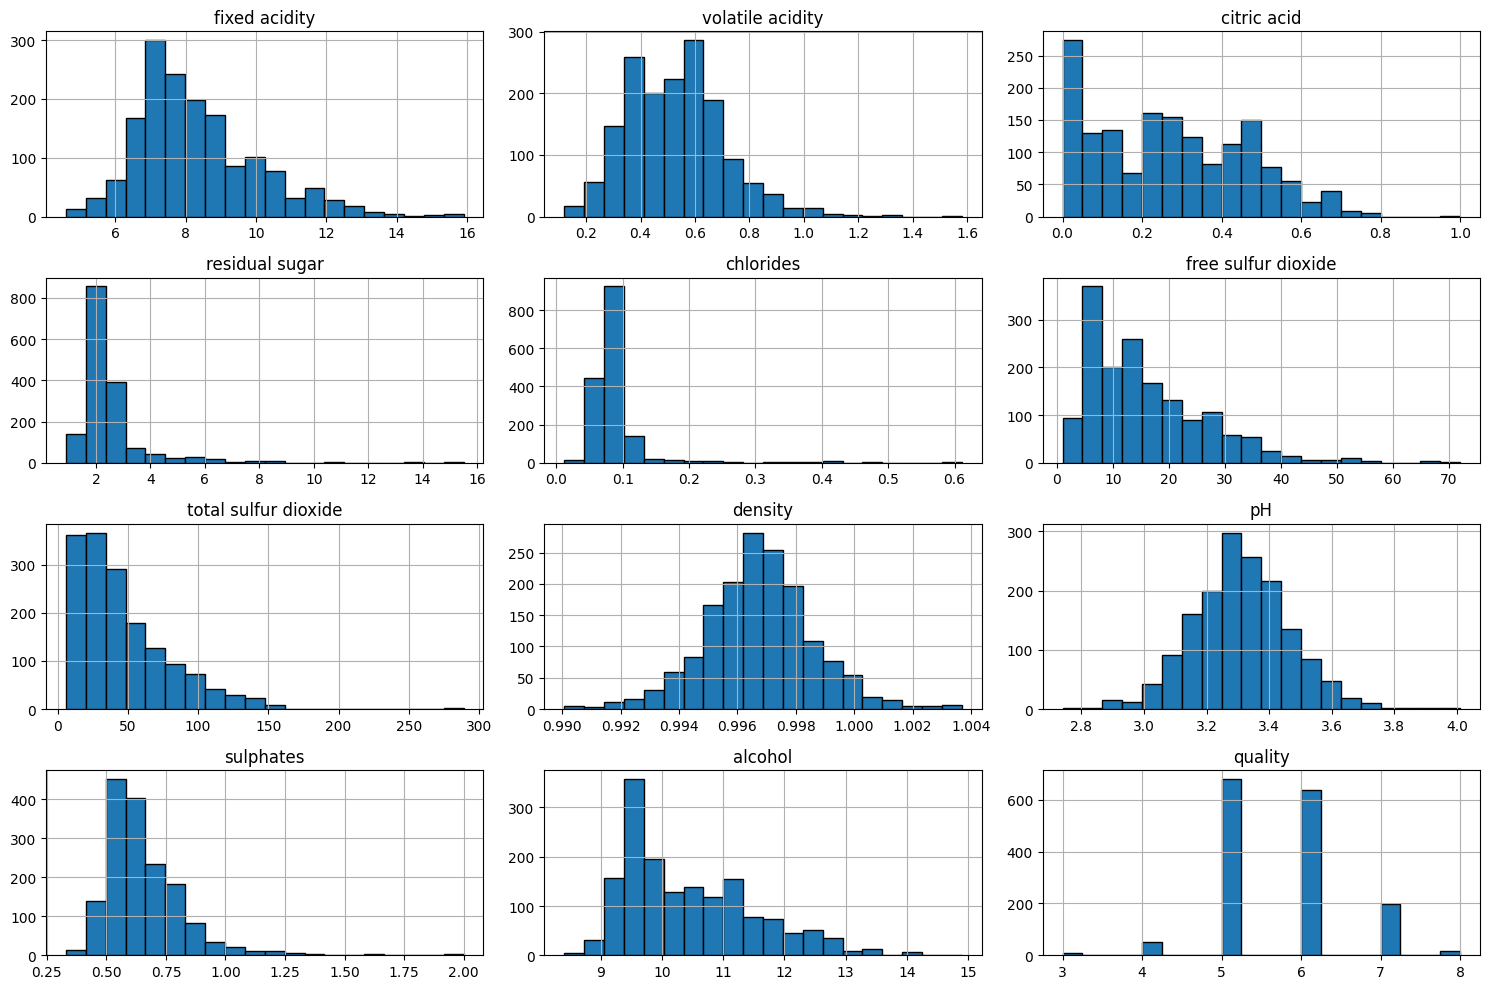

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()
# Plot feature distributions
df.hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

#Prepare the Data for Machine Learning Algorithms

In [4]:
# Handle missing values (if any)
df.fillna(df.mean(), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
from sklearn.preprocessing import RobustScaler, QuantileTransformer

# Define feature matrix and target variable
X = df.drop('quality', axis=1)
y = df['quality']

# Scaling and normalizing the data
if X.skew().abs().max() > 1:
    scaler = QuantileTransformer(output_distribution='normal')
else:
    scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

#Select a Model and Train It

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Define and train models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42)
}

# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} - R²: {r2:.4f}, MSE: {mse:.4f}")


Random Forest - R²: 0.3843, MSE: 0.3217
Gradient Boosting - R²: 0.3815, MSE: 0.3231
Extra Trees - R²: 0.3830, MSE: 0.3224


#Fine-tune Your Model

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Increase this for more exhaustive search
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the tuned model
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Tuned Extra Trees - R²: {r2:.4f}, MSE: {mse:.4f}")


Tuned Extra Trees - R²: 0.3873, MSE: 0.3201


#Test Your Model on the Test Dataset

In [7]:
import joblib

# Final evaluation
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Final Model - R²: {r2:.4f}, MSE: {mse:.4f}")

# Save the model
joblib.dump(best_model, 'extra_trees_model.pkl')


Final Model - R²: 0.3873, MSE: 0.3201


['extra_trees_model.pkl']